# AlphaGear POC

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Basic functions
from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent

# Custom function for the environment and reward function
from environment_alphagear import RiskEnvironmentPOC

# Custom functions for the agent functions
from agent_funcs import *
from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil

### Agent

In [2]:
class ExpectedSarsaAgent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], agent_config['minibatch_sz']) #, agent_config.get("seed")) #in agent_funcs
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        self.step_by_step = agent_config['step_by_step']
        
        self.rand_generator = np.random.RandomState() #agent_config.get("seed")
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0

    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        
        The state is normalized by dividing by the potential resources of both players
        Note: slightly different than the approach here: http://kth.diva-portal.org/smash/get/diva2:1514096/FULLTEXT01.pdf        
        Hence the span is possibly, but not always, (-1, 1)
        Returns:
            the action. 
        """
        abs_state = np.abs(state[0])
        abs_troops_sum = np.nansum(abs_state, dtype = np.float64)
        state[0] = state[0] / abs_troops_sum 
        tau_corrected = self.tau / abs_troops_sum
        
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, tau_corrected)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        
        if self.step_by_step:
            print("The State is:")
            print(state)
            print("The Action Values are:")
            print(action_values)
            print("With Tau = " + str(self.tau) + "  the Softmax probabilities are:")
            print(probs_batch)
            print("The selected action is: " +str(action) + " which should be equal to the next action picked below")
            
        return action

    # Work Required: No.
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    # weights update using optimize_network, and updating last_state and last_action.
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, False, state)
           
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                
                
        # Update the last state and last action.
        self.last_state = state
        self.last_action = action      
        
        return action

    # update of the weights using optimize_network.
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, True, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                    
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

## Test

100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [28:34:31<00:00, 102871.51s/it]


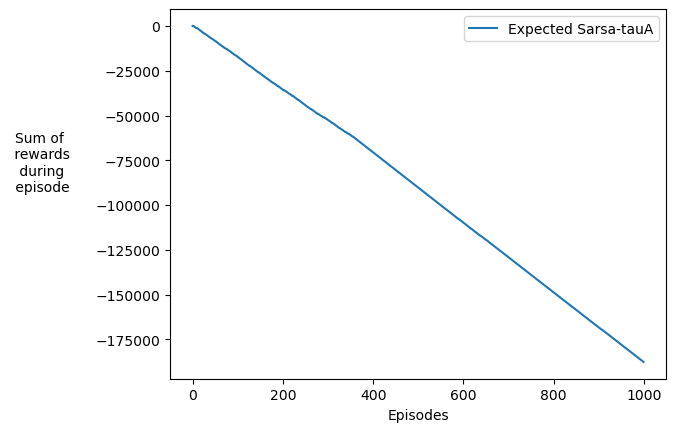

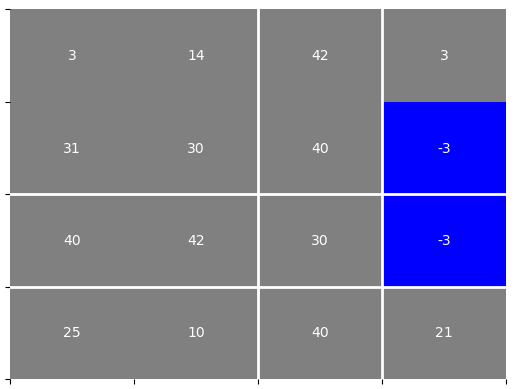

In [3]:
### Script is a combination of the experiment scripts from 2.3 and 4.2

# Experiment parameters
num_runs = 1 #100 The number of runs - take average to reduce variance
num_episodes = 1000 #200 # The number of episodes in each run - it is a single game played to completion
max_steps_episode = 400 #500
step_by_step = False #plots information on a step by step basis

# Environment parameters
num_states = 16 
num_actions_per_state = 4
num_actions = num_states*num_actions_per_state+1 
num_hidden_units = (num_states*32)
#### MAX TROOPS PER SQUARE???

env_info = {'states':num_states, "num_actions":num_actions_per_state}

environment = RiskEnvironmentPOC

all_reward_sums = {} # Contains sum of rewards
all_num_steps = {} 
all_state_visits = {} # Contains state visit counts during the last 10 episodes

# Agent parameters
agents = {
    #"Expected Sarsa": ExpectedSarsaAgent
    "Expected Sarsa-tauA": ExpectedSarsaAgent
    #,"Expected Sarsa-tauB": ExpectedSarsaAgent
    #,"Expected Sarsa-tauC": ExpectedSarsaAgent
    #,"Expected Sarsa-tauD": ExpectedSarsaAgent
    #,"Expected Sarsa-tauE": ExpectedSarsaAgent
}
# should be 32 x states for the hidden variables
agent_info = {
    'network_config': {
        'state_dim': num_states,
        'num_hidden_units': num_hidden_units,
        'num_actions': num_actions,
        'num_hidden_layers': 2
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.95,
    'tau': 0.1,
    'step_by_step': step_by_step
}

#tau = [0.1, 1, 10, 100]
tau = [0.1]

'''
Tau observations
0.01 is much too small initialy

only tau = 100 showed the likelihood of finishing the map

'''

### EXPERIMENT SCRIPT

count_agent = 0

for algorithm in agents:
    all_reward_sums[algorithm] = []
    all_num_steps[algorithm] = []
    all_state_visits[algorithm] = []
    
    if len(agents) > 1:
        agent_info['tau'] = tau[count_agent]
    
    for run in tqdm(range(num_runs)):
        # agent_info["seed"] = run # This seeds the random number generator - not used
        
        # Agent initialization
        rl_glue = RLGlue(environment, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)
        
        reward_sums = []
        num_steps = []
        #state_visits = np.zeros(num_states)
        
        for episode in range(num_episodes):
            rl_glue.rl_episode(max_steps_episode)
            reward_sums.append(rl_glue.rl_return())  # rl_return() returns the total reward across episodes after the env initialization          
            num_steps.append(rl_glue.rl_num_steps())
            '''
            if episode < num_episodes - 10:
                # Runs an episode without recording... due to the variance?
                rl_glue.rl_episode(max_steps_episode) 
            else: 
                # Runs an episode while keeping track of visited states ONLY FOR LAST 10 EPISODES
                state, action = rl_glue.rl_start()
                #state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    #state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
            '''    
        all_reward_sums[algorithm].append(reward_sums)
        all_num_steps[algorithm].append(num_steps)
        #all_state_visits[algorithm].append(state_visits)
    
    count_agent += 1

# plot results
for algorithm in agents:
    # Plots the AVERAGE sum of rewards across runs for an Episode 
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.legend()
plt.show()

rl_glue.env_print_state()

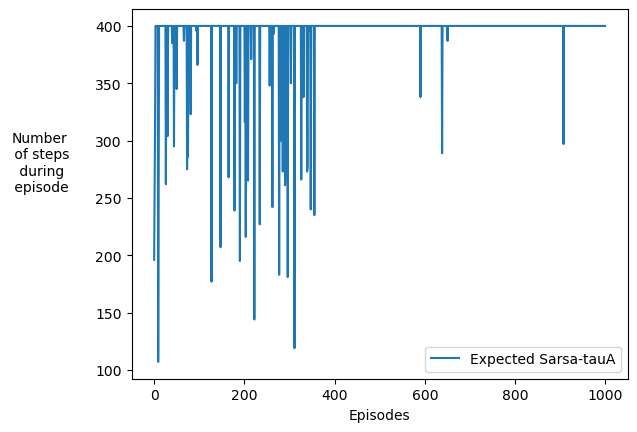

In [4]:
# plot results
for algorithm in agents:
    # Plots the AVERAGE sum of rewards across runs for an Episode 
    plt.plot(np.mean(all_num_steps[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Number\n of steps\n during\n episode",rotation=0, labelpad=40)
plt.legend()
plt.show()

In [5]:
all_num_steps[algorithm]

[[196,
  256,
  311,
  400,
  400,
  400,
  400,
  400,
  400,
  107,
  245,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  262,
  400,
  400,
  400,
  304,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  385,
  400,
  400,
  400,
  295,
  400,
  400,
  400,
  400,
  400,
  345,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  387,
  400,
  400,
  400,
  400,
  400,
  400,
  275,
  400,
  286,
  400,
  400,
  400,
  400,
  400,
  323,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  396,
  400,
  400,
  366,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  177,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,
  400,

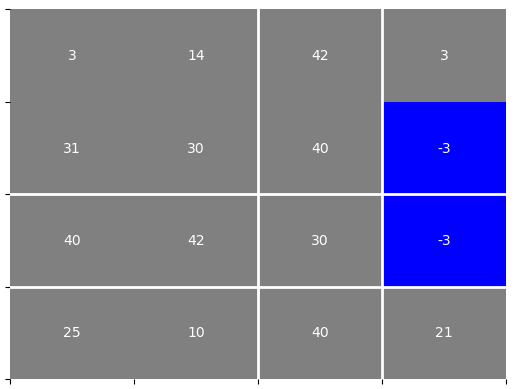

In [6]:
rl_glue.env_print_state()

### TO DO
- Meta parameter tuning
    - If softmax - Reduce tau as a function of the number of episodes?
        - However, softmax is not best for a large action space
        - Might a gaussian policy parameterization be better?
    - Increase the tau / discount / learning rate factor as a function of the number of episodes?
    - Apply heuristics to reward function
        - (Done) -ve per step
        - (Done) +ve per taking territory
        - Maybe the reward scaling isn't good since the action values are randomly initialized between 0 and 1
            - (Done) 100 for winning
- Reduce action-value dimensions and/or improve the NN
    - (Done) Add another layer to the NN
    - (Done) Cap the number of troops on a territory before 'place' step
    - Mask not possible actions

- - Accomodate new environments each run (rather than just a single one)
    - Move environment initialization into Run loop? Or for each new episode?
- Plot the average visits on each square (see assignment 2.3)
    - Note: states are actually high dimension - can't keep track of visits on a state, but maybe attacks to and from?
- Annimate the last episode of the last run
    - Would need to save the images from print_env


##### Major Changes
- Changed the NN weight initialization
- Added another layer
- Normalized the state before feeding NN
- Added state troop number normalization
- Applied heuristics to the reward function (see above)